In [ ]:
!apt install tesseract-ocr
!pip install pymupdf pytesseract opencv-python pillow numpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 80.4 MB/s eta 0:00:00


In [ ]:
import fitz  # PyMuPDF
import pytesseract
from PIL import Image
import cv2
import numpy as np

In [ ]:
pdf_path = "MTG_10009588.pdf"
dpi = 200

In [ ]:
#OCR with preprocessing
def ocr_image(img_cv):
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    denoised = cv2.medianBlur(thresh, 3)
    return pytesseract.image_to_data(denoised, output_type=pytesseract.Output.DICT)

In [ ]:
#MAIN
doc = fitz.open(pdf_path)
results = []

for page_num in range(len(doc)):
    page = doc[page_num]
    pix = page.get_pixmap(dpi=dpi)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Split into chunks for speed
    height = img_cv.shape[0]
    chunks = [
        img_cv[0:height//3, :],
        img_cv[height//3:2*height//3, :],
        img_cv[2*height//3:, :]
    ]

    for chunk_index, chunk in enumerate(chunks):
        data = ocr_image(chunk)
        for i in range(len(data['text'])):
            text = data['text'][i].strip()
            if text:
                keywords = ["borrower", "lender", "loan", "property", "address", "date", "mortgage", "deed", "trust", "amount"]
                if any(k in text.lower() for k in keywords) or any(c.isdigit() for c in text):
                    bbox = (
                        data['left'][i],
                        data['top'][i] + chunk_index * (height // 3),
                        data['width'][i],
                        data['height'][i]
                    )
                    results.append({
                        "page": page_num + 1,
                        "text": text,
                        "bbox": bbox
                    })

In [ ]:
#Preview before cleaning
print(f"OCR complete. Found {len(results)} keyword-matching entries.")
for entry in results[:20]:
    print(entry)

OCR complete. Found 150 keyword-matching entries.
{'page': 1, 'text': 'MORTGAGE', 'bbox': (747, 130, 207, 55)}
{'page': 1, 'text': '10009588', 'bbox': (1308, 141, 160, 36)}
{'page': 1, 'text': '06/28/2011', 'bbox': (1253, 213, 101, 21)}
{'page': 1, 'text': '09:35AN', 'bbox': (1377, 214, 73, 18)}
{'page': 1, 'text': 'ADDRESS', 'bbox': (531, 256, 95, 16)}
{'page': 1, 'text': 'DEEDS', 'bbox': (1331, 265, 51, 18)}
{'page': 1, 'text': 'AMOUNT', 'bbox': (1178, 311, 71, 30)}
{'page': 1, 'text': '30.00', 'bbox': (1342, 301, 56, 42)}
{'page': 1, 'text': '4121', 'bbox': (350, 330, 46, 16)}
{'page': 1, 'text': '50322', 'bbox': (525, 355, 60, 17)}
{'page': 1, 'text': '716-0027-6', 'bbox': (352, 479, 119, 18)}
{'page': 1, 'text': '$81', 'bbox': (1064, 579, 33, 17)}
{'page': 1, 'text': '-4247085-703', 'bbox': (1104, 579, 145, 17)}
{'page': 1, 'text': '100273100009309945', 'bbox': (974, 629, 222, 17)}
{'page': 1, 'text': '(Borrower")', 'bbox': (349, 954, 111, 19)}
{'page': 1, 'text': 'Mortgage', 'bbo

In [ ]:
import re

In [ ]:
def clean_text_overall(text):
    # 1. Basic strip
    text = text.strip()

    # 2. Common OCR replacements (generic, not only mortgage-related)
    replacements = {
        "ﬁ": "fi",   # ligature fix
        "ﬂ": "fl",
        "1s": "is",
        "lS": "is",
        "Oate": "Date",
        "Borr0wer": "Borrower",
        "L0an": "Loan",
        "Propertv": "Property",
        "M0rtgage": "Mortgage",
        "Addr3ss": "Address"
    }
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)

    # 3. Fix common number/letter confusion
    text = re.sub(r"\b0([A-Za-z])", r"O\1", text)  # 0 → O at start of word
    text = re.sub(r"\b([A-Za-z])0\b", r"\1O", text)  # O at end
    text = re.sub(r"\b1([A-Za-z])", r"I\1", text)   # 1 → I

    # 4. Time fixes (09:35AN → 09:35AM)
    text = re.sub(r"(\d{1,2}:\d{2})AN\b", r"\1AM", text)
    text = re.sub(r"(\d{1,2}:\d{2})PN\b", r"\1PM", text)

    # 5. Date normalization (MM-DD-YYYY or MM/DD/YYYY)
    text = re.sub(r"(\d{1,2})[-\.](\d{1,2})[-\.](\d{4})", r"\1/\2/\3", text)

    # 6. Remove stray punctuation at start/end
    text = text.strip(" ,.;:()[]{}\"'")

    # 7. Collapse multiple spaces
    text = re.sub(r"\s+", " ", text)

    return text.strip()


In [ ]:
#Run cleaning on extracted results
results_cleaned = []
for entry in results:
    cleaned = clean_text_overall(entry['text'])
    if cleaned:
        results_cleaned.append({
            "page": entry['page'],
            "text": cleaned,
            "bbox": entry['bbox']
        })

print(f"Cleaning complete. {len(results_cleaned)} entries remain after cleaning.")
for entry in results_cleaned[:20]:
    print(entry)


Cleaning complete. 150 entries remain after cleaning.
{'page': 1, 'text': 'MORTGAGE', 'bbox': (747, 130, 207, 55)}
{'page': 1, 'text': '10009588', 'bbox': (1308, 141, 160, 36)}
{'page': 1, 'text': '06/28/2011', 'bbox': (1253, 213, 101, 21)}
{'page': 1, 'text': '09:35AM', 'bbox': (1377, 214, 73, 18)}
{'page': 1, 'text': 'ADDRESS', 'bbox': (531, 256, 95, 16)}
{'page': 1, 'text': 'DEEDS', 'bbox': (1331, 265, 51, 18)}
{'page': 1, 'text': 'AMOUNT', 'bbox': (1178, 311, 71, 30)}
{'page': 1, 'text': '30.00', 'bbox': (1342, 301, 56, 42)}
{'page': 1, 'text': '4121', 'bbox': (350, 330, 46, 16)}
{'page': 1, 'text': '50322', 'bbox': (525, 355, 60, 17)}
{'page': 1, 'text': '716-0027-6', 'bbox': (352, 479, 119, 18)}
{'page': 1, 'text': '$81', 'bbox': (1064, 579, 33, 17)}
{'page': 1, 'text': '-4247085-703', 'bbox': (1104, 579, 145, 17)}
{'page': 1, 'text': '100273100009309945', 'bbox': (974, 629, 222, 17)}
{'page': 1, 'text': 'Borrower', 'bbox': (349, 954, 111, 19)}
{'page': 1, 'text': 'Mortgage', 'bb

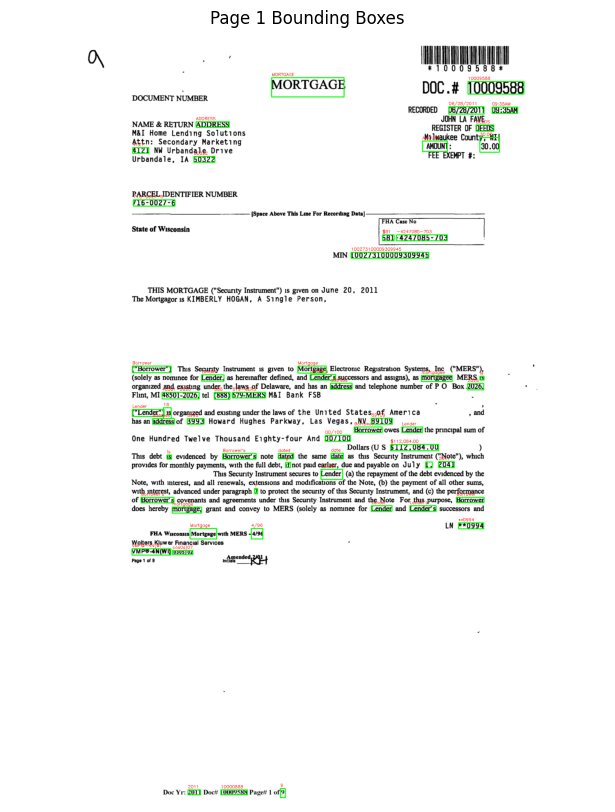

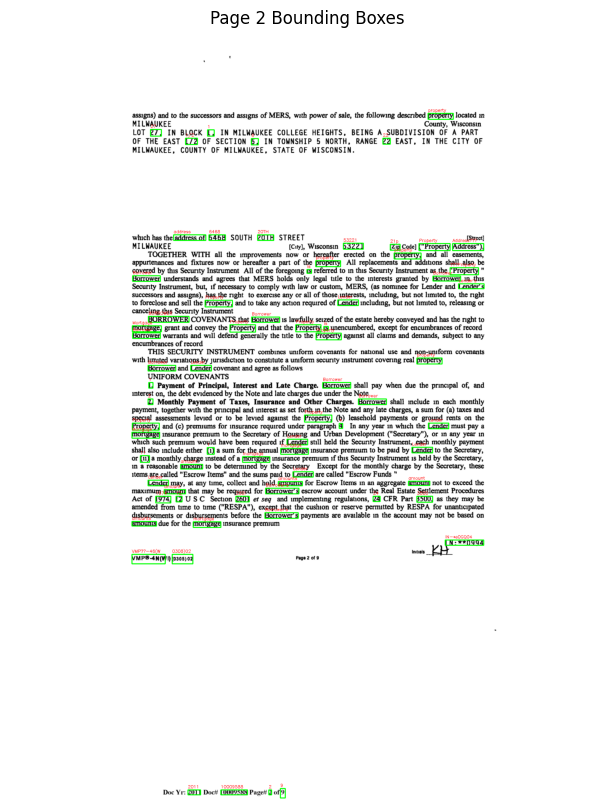

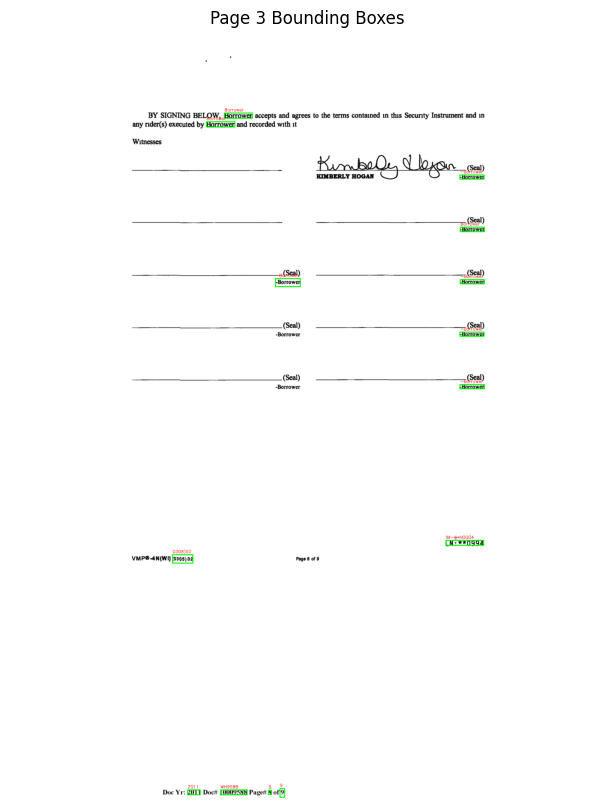

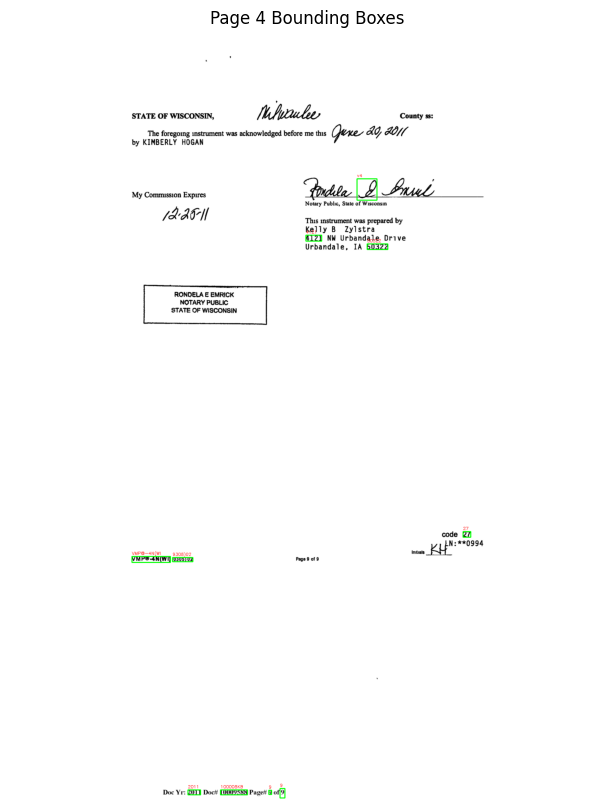

In [ ]:
import matplotlib.pyplot as plt

# Loop through all pages in the PDF
for page_index in range(len(doc)):
    # Convert PDF page to image
    page = doc[page_index]
    pix = page.get_pixmap(dpi=dpi)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Draw bounding boxes for entries on this page
    for entry in results_cleaned:
        if entry['page'] == page_index + 1:
            x, y, w, h = entry['bbox']
            cv2.rectangle(img_cv, (x, y), (x + w, y + h), (0, 255, 0), 2)  # green box
            cv2.putText(img_cv, entry['text'], (x, max(10, y - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)  # red text

    # Convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    # Display the page with bounding boxes
    plt.figure(figsize=(12, 10))
    plt.title(f"Page {page_index + 1} Bounding Boxes")
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()


In [ ]:
import json

# Fields to extract with their keywords
fields_to_extract = {
    "Borrower": ["borrower"],
    "Lender": ["lender"],
    "Loan Amount": ["amount", "loan"],
    "Property Address": ["address", "property"],
    "Dates": ["date"],
    "Document Title": ["mortgage", "deed", "trust"]
}

structured_data = {}

for field, keywords in fields_to_extract.items():
    for entry in results_cleaned:
        text_lower = entry['text'].lower()
        if any(k in text_lower for k in keywords):
            structured_data[field] = {
                "value": entry['text'],
                "bbox": entry['bbox']
            }
            break

# Save JSON
with open("mortgage_structured.json", "w") as f:
    json.dump(structured_data, f, indent=4)

# Preview JSON
print(json.dumps(structured_data, indent=4))


{
    "Borrower": {
        "value": "Borrower",
        "bbox": [
            349,
            954,
            111,
            19
        ]
    },
    "Lender": {
        "value": "Lender",
        "bbox": [
            547,
            979,
            64,
            18
        ]
    },
    "Loan Amount": {
        "value": "AMOUNT",
        "bbox": [
            1178,
            311,
            71,
            30
        ]
    },
    "Property Address": {
        "value": "ADDRESS",
        "bbox": [
            531,
            256,
            95,
            16
        ]
    },
    "Dates": {
        "value": "dated",
        "bbox": [
            766,
            1204,
            44,
            15
        ]
    },
    "Document Title": {
        "value": "MORTGAGE",
        "bbox": [
            747,
            130,
            207,
            55
        ]
    }
}
